# 03 - Features Fundamentais dos Modelos de Time Series

## Introdução

Vamos ver as features mais basicas que devemos gerar ao fazer um trabalho de engenharia de atributos para series temporais.

## Importação

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

## Carga dos Dados

Note que vamos utilizar os dados com Y de quatro pontos de diferença, vamos tentar prever Y 4 pontos a frente (cada ponto aqui é igual a 15 min, logo estamos tentando prever a geração de energia 1 hora a frente do momento atual).

In [3]:
full = pd.read_csv("data-processed/full_direct_df.csv")
full['DATE_TIME'] = pd.to_datetime(full['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full.sort_values("DATE_TIME")
full.iloc[50:55]

,Unnamed: 0,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,15M_YIELD,Y4
50,50,2020-05-15 12:30:00,4135001,1BY6WEcLGh8j5v7,8517.000000,832.962500,2860.000000,6262419.000,32.147685,52.353255,0.649248,245.428571,158.142857
51,51,2020-05-15 12:45:00,4135001,1BY6WEcLGh8j5v7,8006.285714,783.557143,3062.000000,6262621.000,32.391420,50.631240,0.761243,202.000000,183.875000
52,52,2020-05-15 13:00:00,4135001,1BY6WEcLGh8j5v7,6089.375000,596.562500,3223.250000,6262782.250,32.622796,49.610768,0.416035,161.250000,209.839286
53,53,2020-05-15 13:15:00,4135001,1BY6WEcLGh8j5v7,6359.714286,623.042857,3384.857143,6262943.857,32.497064,47.011161,0.489244,161.607143,254.285714
54,54,2020-05-15 13:30:00,4135001,1BY6WEcLGh8j5v7,7588.000000,742.914286,3543.000000,6263102.000,32.524621,46.669863,0.574561,158.142857,207.142857


## Split Dados

In [4]:
full['DATE_TIME'].describe()

<ipython-input-4-b0f1ee3fd917>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  full['DATE_TIME'].describe()


count                   68690
unique                   3154
top       2020-05-25 15:45:00
freq                       22
first     2020-05-15 00:00:00
last      2020-06-17 22:45:00
Name: DATE_TIME, dtype: object

In [5]:
full.groupby(full['DATE_TIME'].dt.month).size()

DATE_TIME
5    33112
6    35578
dtype: int64

In [6]:
split_date = "2020-06-01"

train = full[full['DATE_TIME'] < split_date]
val = full[full['DATE_TIME'] >= split_date]

train.shape, val.shape

((33112, 13), (35578, 13))

## Baseline

Nossa baseline vai ser a média simples dos dados agrupados.

In [11]:
train2 = train.copy()

train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

base_pred = train2.groupby(['WEEKDAY','HOUR', 'MINUTE'], as_index=False)['Y4'].mean()
base_pred = base_pred.rename(columns={"Y4": "P"}) # 15M_YIELD?

base_pred

,WEEKDAY,HOUR,MINUTE,P
0,0,0,0,0.000000
1,0,0,15,0.000000
2,0,0,30,0.000000
3,0,0,45,0.000000
4,0,1,0,0.000000
...,...,...,...,...
667,6,22,45,-539.571429
668,6,23,0,0.000000
669,6,23,15,0.000000
670,6,23,30,0.000000


In [12]:
val2 = val.copy()

val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

val2 = pd.merge(val2, base_pred, on=['WEEKDAY', 'HOUR', 'MINUTE'])

val2.head()

,Unnamed: 0,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,15M_YIELD,Y4,WEEKDAY,HOUR,MINUTE,P
0,1525,2020-06-01,4135001,1BY6WEcLGh8j5v7,0.0,0.0,829.000000,6377931.0,23.128673,20.464305,0.0,0.0,0.0,0,0,0,0.0
1,2196,2020-06-08,4135001,1BY6WEcLGh8j5v7,0.0,0.0,752.571429,6423750.0,23.316430,22.217734,0.0,0.0,0.0,0,0,0,0.0
2,2868,2020-06-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000000,6467675.0,23.369126,22.693622,0.0,0.0,0.0,0,0,0,0.0
3,4646,2020-06-01,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000000,6311432.0,23.128673,20.464305,0.0,0.0,0.0,0,0,0,0.0
4,5311,2020-06-08,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000000,6363338.0,23.316430,22.217734,0.0,0.0,0.0,0,0,0,0.0


Erro:  3.613771830227013


<AxesSubplot:>

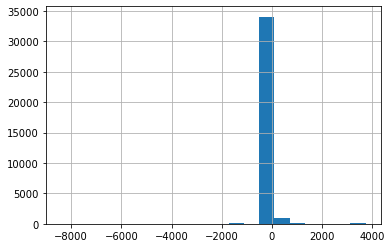

In [17]:
from sklearn.metrics import median_absolute_error

print("Erro: ", median_absolute_error(val2['Y4'], val2['P']))

(val2['Y4']-val2['P']).hist(bins=20)

## Baseline com Machine Learning

Vamos também fazer um baseline com algum modelo de machine learning. 

In [21]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train[features].fillna(-1), train['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val[features].fillna(-1))

# Nosso erro é bem maior que a outra baseline mais simples
print("Erro: ", median_absolute_error(val['Y4'], p))

Erro:  7.092791687149965


## Lag

Lag é um valor anterior da variável que estamos querendo prever (ou pode ser das outras variáveis tambem).

Não podemos fazer lag com Y4 por que só teremos o valor dele daqui a 4 coletas. Isso é vazamento de dados: Temos o dado no nosso processo aqui, mas em produção esses dados não vão existir.

In [25]:
lags = [1, 4, 8, 16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            source_key_df['LAG{}_{}'.format(l, f)] = source_key_df[f].shift(l)
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['LAG{}_{}'.format(l, f)] = source_key_df[f].shift(l)
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [26]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Nosso erro ainda continua ruim, bem similar ao anterior
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  7.259345245000496


## EXTRA: Leakage

In [27]:
train2[train2['SOURCE_KEY'] == '1BY6WEcLGh8j5v7'][['DATE_TIME', 'SOURCE_KEY','15M_YIELD','Y4']].iloc[15:30]

,DATE_TIME,SOURCE_KEY,15M_YIELD,Y4
15,2020-05-15 03:45:00,1BY6WEcLGh8j5v7,0.000000,0.000000
16,2020-05-15 04:00:00,1BY6WEcLGh8j5v7,0.000000,0.000000
17,2020-05-15 04:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000
18,2020-05-15 04:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000
19,2020-05-15 04:45:00,1BY6WEcLGh8j5v7,0.000000,0.000000
20,2020-05-15 05:00:00,1BY6WEcLGh8j5v7,0.000000,0.000000
21,2020-05-15 05:15:00,1BY6WEcLGh8j5v7,0.000000,2.625000
22,2020-05-15 05:30:00,1BY6WEcLGh8j5v7,0.000000,10.660714
23,2020-05-15 05:45:00,1BY6WEcLGh8j5v7,0.000000,21.589286
24,2020-05-15 06:00:00,1BY6WEcLGh8j5v7,0.000000,37.839286


## Dif

No Lag apenas pegamos os valores anteriores. Já na diferenciação fazemos a subtração do valor atual com um valor passado (t-(t-1)).

In [28]:
lags = [1, 4, 8, 16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('DIFF{}_{}'.format(l, f))
            source_key_df['DIFF{}_{}'.format(l, f)] = source_key_df[f].diff(l)
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['DIFF{}_{}'.format(l, f)] = source_key_df[f].diff(l)
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [29]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Não tivemos melhoria...
# Isso indica que a taxa de mudança entre um registro e outro não parece ser importante
# Lag por hora parece mais importante, ou seja, está fazendo mais sentido considerar os valores reais que estão mudando com o tempo
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  7.3005357495000425


## Rolling Statistics

Pega os últimos n registros e cálcula alguma métrica com eles. Esse cálculo vai sendo feito em janelas.

In [30]:
lags = [1, 4, 8, 16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            source_key_df['ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f].rolling(l).mean()
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f].rolling(l).mean()
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [32]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Nosso erro ficou ainda pior...
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  8.467565237340988


## EXTRA: Current Minus Rolling (Delta Roll)

Basicamente é o valor atual menos a métrica móvel que foi calculada.

In [33]:
lags = [1,4,8,16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            source_key_df['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f] - source_key_df[f].rolling(l).mean()
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f] - source_key_df[f].rolling(l).mean()
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [35]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Foi menos pior que Rolling Statistics pura, mas ainda continua ruim
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  8.024126191444823


## Componentes de Data Com Outras Features

Extraímos algumas features do campo data. Ao adicionar componentes de datas, o modelo consegue captar mais facilmente padrões de sazonaliadades dos dados.

In [37]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD', 
            'WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

In [39]:
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Houve uma melhora considerável, apesar de não bater a primeira baseline
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  4.03928572099997


## Componentes de Data Sem Outras Features

In [42]:
features = ['WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

In [43]:
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Chegou bem próximo a nossa baseline pura
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  3.6152617739372404


## EXTRA: Winsorize

Aqui pegamos os valores mais altos e arredondamos para o valor mais alto que aceitamos. O mesmo é feito com valores mais baixos.

Exempplo: Temos valores de 1 a 10, e não nos interessa tanto assim os valores (1, 2) e nem os valores (9, 10). Arredondamos os mais baixos para 3, e os mais altos para 8.

In [50]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD', 
            'WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

winsor_lower = np.percentile(train2['Y4'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train2['Y4'], 99)
train2['Y4WIN'] = train2['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

#val2['Y4WIN'] = val2['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

In [51]:
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4WIN']

mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))

# Tivemos uma melhora significativa no erro!
print("Erro: ", median_absolute_error(val2['Y4'], p))

Erro:  2.446878056058055


## Grava Dados Tratados

In [53]:
winsor_lower = np.percentile(train['Y4'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train['Y4'], 99)
train['Y4WIN'] = train['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

<ipython-input-53-5169a1fc621b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Y4WIN'] = train['Y4'].clip(lower=winsor_lower, upper=winsor_upper)


In [54]:
train.reset_index().to_csv("data-processed/train.csv")
val.reset_index().to_csv("data-processed/val.csv")

# Fim